In [1]:
# Install uproot to be able open ROOT files
#pip install uproot

# Plots for the Invisible Higgs Decay Simulation Analysis

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import sys
from collections import defaultdict

## A test to see the histograms proprieties

In [3]:
# 1️⃣ Get the directory that contains this script
current_dir = pathlib.Path.cwd()         # e.g. …/project

# 2️⃣ Move up to the parent folder (if you’re already there, this is optional)
parent_dir = current_dir.parent             # e.g. …/ (same as project in this case)
# 3️⃣ Navigate to the sibling folder and file you need
#    Replace 'data' and 'dataset.csv' with your actual folder/file names
target_path = parent_dir / "output_files"
sig_target_path = parent_dir / "output_files" / "signal_20251027_155520_hist.root"
bg_target_path = parent_dir / "output_files" / "background_20251222_002023_hist.root"
# 4️⃣ If you just need the string representation:
sig_target_path_str = str(sig_target_path)
bg_target_path_str = str(bg_target_path)

print("Signal Full path:", sig_target_path)
print("Background Full path:", bg_target_path)

Signal Full path: /home/mazeeqe/Documents/mestrado/code/tomaz-example/output_files/signal_20251027_155520_hist.root
Background Full path: /home/mazeeqe/Documents/mestrado/code/tomaz-example/output_files/background_20251222_002023_hist.root


In [4]:
def load_branch(tree,branch):
    '''
    Loads a ROOT branch into a Numpy array
    '''
    return tree[branch].array(library="np")

def load_histograms(file_path: pathlib.Path):

    file = uproot.open(file_path)

    # Import Events
    tree = file["events"]
    
    #df_list = []
    data_dict = {}
    
    for branch in tree.keys():
        # Each Branch is stored as an Numpy array
        branch_data = load_branch(tree, branch)

        data_dict[branch] = branch_data

        
    # Turn into a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    df = df.transpose()   # now each original array becomes a row


    return df

### Constants

In [5]:
# Particle Masses
z_mass = 91.1880
h_mass = 125.20

In [6]:
# Open the ROOT file
sig_file = uproot.open(sig_target_path_str)
bg_file = uproot.open(bg_target_path_str)

# Check Available Keys
print(sig_file.keys())

# Import Events
sig_tree = sig_file["events"]
bg_tree = bg_file["events"]

['events;1', 'NumEventsGenerated;1', 'CrossSection_pb;1', 'TargetLuminosity_fb;1']


In [7]:
sig_df = load_histograms(sig_target_path)
print(len(sig_df))
sig_df.head()

2124


,invMass,recoilMass,totalEnergy,muonEnergy_high,muonEnergy_low,px,py,pz,met,missingEnergy,missingPx,missingPy,missingPz,weight
0,90.379295,126.449173,109.358047,60.021561,49.336487,34.691528,-47.737968,-17.559902,59.011997,139.439484,-34.418442,48.874714,17.841278,0.0001
1,91.506042,124.864212,110.564568,63.332569,47.231998,52.715530,9.558616,-31.318913,53.575130,139.140594,-52.648258,-9.524464,31.033895,0.0001
2,91.204819,125.793747,109.988510,75.921379,34.067127,-39.722488,34.966690,-31.282686,52.920181,129.469330,43.313324,-32.509979,30.155424,0.0001
3,87.683578,125.498787,108.876930,84.586945,24.289984,-18.420120,55.115215,28.085360,58.111855,141.123077,18.420120,-55.115215,-28.085360,0.0001
4,92.604996,126.780563,110.004745,83.886017,26.118731,50.504303,-15.520006,27.088806,52.835171,139.995255,-50.504303,15.520006,-27.088806,0.0001


In [8]:
"""
Combine *_hist.root files, but keep signal and background separate.

Features
--------
* Auto‑detects files whose base name starts with "signal_" or "background_".
* Loads all top‑level TH* objects with uproot.
* Sums histograms *within* each category (bin‑by‑bin addition, errors propagated).
* Writes two output ROOT files:
      combined_signal_hist.root
      combined_background_hist.root
* Easy to extend to extra categories – just add a new entry to CATEGORY_MAP.
"""


# ----------------------------------------------------------------------
# 1️⃣  Define how filenames map to a logical category
# ----------------------------------------------------------------------
CATEGORY_MAP = {
    "signal_": "signal",
    "background_": "background",
    # Add more prefixes here if you ever need extra groups, e.g.:
    # "data_": "data",
    # "mc_":   "mc",
}


def infer_category(filename: str) -> str | None:
    """
    Return the category name for a given filename based on its prefix.
    If no prefix matches, return None (the file will be ignored).
    """
    for prefix, cat in CATEGORY_MAP.items():
        if filename.startswith(prefix):
            return cat
    return None


# ----------------------------------------------------------------------
# 2️⃣  Locate all *_hist.root files (adjust the glob pattern if needed)
# ----------------------------------------------------------------------
def find_root_files(root_dir: pathlib.Path) -> list[pathlib.Path]:
    """Return a sorted list of all ROOT files ending with '_hist.root'."""
    pattern = "*_hist.root"
    files = sorted(root_dir.glob(pattern))
    if not files:
        sys.exit(f"No files matching '{pattern}' were found in {root_dir}")
    return files


# ----------------------------------------------------------------------
# 4️⃣  Combine histograms *per category*
# ----------------------------------------------------------------------
def combine_per_category(
    per_file_hists: list):
    """
    Input: list of (category, {name → histogram}) tuples.
    Output: {category → {hist_name → summed_histogram}}.
    """
    combined_by_cat = defaultdict(dict)  # category → (name → summed histogram)

    sig_list = []
    bg_list = []

    for cat, hist_df in per_file_hists:
        # Defensive normalisation – works even if cat is a numpy/pandas scalar
        cat_norm = str(cat).strip().lower()

        if cat == "signal":
            sig_list.append(hist_df)
            
        elif cat == "background":
            bg_list.append(hist_df)

        else:
            # Optional: warn about unexpected categories
            print(f"⚠️  Unexpected category '{cat}' – ignored.")

    # Concatenate each list (empty list → empty DataFrame)
    sig_df = pd.concat(sig_list, axis=0) if sig_list else pd.DataFrame()
    bg_df  = pd.concat(bg_list,  axis=0) if bg_list  else pd.DataFrame()

    # If you still want counts you can compute them here
    sig_count = len(sig_list)
    bg_count  = len(bg_list)
    print(f"Collected {sig_count} signal frames and {bg_count} background frames.")

    return sig_df, bg_df


# ----------------------------------------------------------------------
# 🎬  Main driver
# ----------------------------------------------------------------------


def main():
    # Directory that holds your *_hist.root files – change if needed
    root_dir = pathlib.Path(target_path)

    # 1️⃣ Find files
    files = find_root_files(root_dir)
    print(f"🔎 Discovered {len(files)} *_hist.root file(s):")
    for p in files:
        print(f"   • {p.name}")

    # 2️⃣ Load histograms and tag each with its inferred category
    per_file_hists = []  # List of (category, {name → hist}) tuples
    for p in files:
        cat = infer_category(p.name)
        if cat is None:
            print(f"⚠️  Skipping {p.name}: unknown prefix (not signal_/background_)")
            continue

        hists = load_histograms(p)
        if hists.empty:
            print(f"⚠️  No histograms found in {p.name}")
        else:
            print(f"📂 Loaded {len(hists)} histogram(s) from {p.name} → category '{cat}'")
        per_file_hists.append((cat, hists))

    if not per_file_hists:
        sys.exit("❌ No files matched known categories – nothing to combine.")


    # 3️⃣ Combine within each category
    sig_df, bg_df = combine_per_category(per_file_hists)
    for cat, hist_dict in sig_df.items():
        print(f"🧮 Category '{cat}' produced {len(hist_dict)} combined histogram(s).")

    return sig_df, bg_df

# For some reason the histograms aren't combining
nsig_df, nbg_df = main()

🔎 Discovered 17 *_hist.root file(s):
   • background_20251222_002023_hist.root
   • background_20251222_031721_hist.root
   • background_20251222_154147_hist.root
   • background_20251222_155322_hist.root
   • signal_20251027_155520_hist.root
   • signal_20251027_160029_hist.root
   • signal_20251104_043801_hist.root
   • signal_20251105_022857_hist.root
   • signal_20251112_045545_hist.root
   • signal_20251210_022746_hist.root
   • signal_20251215_010551_hist.root
   • signal_20251221_052544_hist.root
   • signal_20251222_002016_hist.root
   • signal_20251222_031717_hist.root
   • signal_20251222_154143_hist.root
   • signal_20251222_155015_hist.root
   • signal_hist.root
⚠️  No histograms found in background_20251222_002023_hist.root
⚠️  No histograms found in background_20251222_031721_hist.root
⚠️  No histograms found in background_20251222_154147_hist.root
📂 Loaded 998 histogram(s) from background_20251222_155322_hist.root → category 'background'
📂 Loaded 2124 histogram(s) from s

In [9]:
print(len(nsig_df))
nsig_df.head()

def check_duplicates(df):
    """
    Check if there are duplicated rows in the DataFrame
    """
    # 1️⃣ Boolean check – is there any duplicate row?
    has_duplicates = df.duplicated().any()
    print("Has Duplicated Rows:",has_duplicates)          # False → no repeated rows
    
    # 2️⃣ Count of duplicate rows
    num_duplicates = df.duplicated().sum()
    percentage_duplicate = num_duplicates/len(df)*100
    print(f"Found a total of {num_duplicates}/{len(df)} ({percentage_duplicate:.2f}%) duplicated row(s).")          # 0 → no repeats
    
    # 3️⃣ Direct assertion – raise an error if a duplicate exists
    no_duplicated_df = df.drop_duplicates()
    
    # 4️⃣ Compare shapes after dropping duplicates
    print("Dropping duplicates.")
    print(f"New DataFrame has lenth: {len(no_duplicated_df)} row(s).")

    return no_duplicated_df

new_nsig_df = check_duplicates(nsig_df)

21112
Has Duplicated Rows: True
Found a total of 15866/21112 (75.15%) duplicated row(s).
Dropping duplicates.
New DataFrame has lenth: 5246 row(s).


In [10]:
print(len(nbg_df))
nbg_df.head()

new_nbg_df = check_duplicates(nbg_df)

998
Has Duplicated Rows: False
Found a total of 0/998 (0.00%) duplicated row(s).
Dropping duplicates.
New DataFrame has lenth: 998 row(s).


In [11]:
nsig_df.columns

Index(['invMass', 'recoilMass', 'totalEnergy', 'muonEnergy_high',
       'muonEnergy_low', 'px', 'py', 'pz', 'met', 'missingEnergy', 'missingPx',
       'missingPy', 'missingPz', 'weight'],
      dtype='object')

In [12]:
# Functions to import the ROOT branches into Numpy arrays
def load_branch(tree,branch):
    '''
    Loads a ROOT branch into a Numpy array
    '''
    return tree[branch].array(library="np")

def filter_between(arr, low, high):
    """
    Filter the array between two values
    """
    filtered = arr[(arr >= low) & (arr <= high)]

    return filtered
    
# MC weights
weights = load_branch(sig_tree,"weight")

# Load branches into numpy arrays
sig_invMass = nsig_df["invMass"]
sig_recoilMass = nsig_df["recoilMass"]

bg_invMass = nbg_df["invMass"]
bg_recoilMass = nbg_df["recoilMass"]



sig_filtered_invMass = filter_between(sig_invMass, 80, 100)
sig_filtered_recoilMass = filter_between(sig_recoilMass, 110, 150)

bg_filtered_invMass = filter_between(bg_invMass, 80, 100)
bg_filtered_recoilMass = filter_between(bg_recoilMass, 110, 150)

In [13]:
print("Total expected events =", weights.sum())
# Access parameters
num_events = sig_file["NumEventsGenerated"].value
cross_section = sig_file["CrossSection_pb"].value
target_lumi = sig_file["TargetLuminosity_fb"].value

print("Ngen =", num_events)
print("σ =", cross_section, "pb")
print("L =", target_lumi, "fb^-1")

Total expected events = 0.21239997
Ngen = 10000
σ = 1.0 pb
L = 1.0 fb^-1


## 1-D Histogram Function

In [14]:
def plot_histogram(
    signal_data,
    background_data=None,
    *,
    v_line=None,
    bins=100,
    range_min=0,
    range_max=150,
    signal_color="#1f77b4",
    background_color="#ff7f0e",
    signal_label="Signal",
    background_label="Background",
    title="Energy of Two Muons",
    xlabel=r"$E$ \[GeV\]",
    ylabel="Events",
    figsize=(8, 6),
    grid_alpha=0.3,
    save_path="muon_energy.png",
    show_plot=True,
):
    """
    Plot a 1‑D histogram for signal and background (optional) data.

    Parameters
    ----------
    signal_energy : array‑like
        Energy values for the primary (signal) sample.
    background_energy : array‑like, optional
        Energy values for a secondary/background sample.  If provided a second
        histogram is drawn on top of the signal histogram.
    bins : int, default 100
        Number of histogram bins.
    range_min, range_max : float, default 0, 150
        Lower and upper bounds of the histogram range (in GeV).
    signal_color, background_color : str, default Matplotlib defaults
        Colours for the two histograms.
    signal_label, background_label : str
        Labels shown in the legend.
    title, xlabel, ylabel : str
        Text for the plot title and axis labels.
    figsize : tuple, default (8, 6)
        Size of the Matplotlib figure.
    grid_alpha : float, default 0.3
        Transparency of the grid lines.
    save_path : str, default "muon_energy.png"
        Destination filename for the saved PNG.
    show_plot : bool, default True
        If True, displays the figure via ``plt.show()``.
    """
    # ------------------------------------------------------------------
    # Convert inputs to NumPy arrays (ensures compatibility with .hist)
    # ------------------------------------------------------------------
    signal_arr = np.asarray(signal_data)
    if background_data is not None:
        background_arr = np.asarray(background_data)

    # ------------------------------------------------------------------
    # Set up the figure / axes
    # ------------------------------------------------------------------
    plt.figure(figsize=figsize)

    # ------------------------------------------------------------------
    # Primary (signal) histogram
    # ------------------------------------------------------------------
    plt.hist(
        signal_arr,
        bins=bins,
        range=(range_min, range_max),
        histtype="step",
        color=signal_color,
        label=signal_label,
        linewidth=1.5,
    )

    # ------------------------------------------------------------------
    # Optional background histogram (drawn with a semi‑transparent fill)
    # ------------------------------------------------------------------
    if background_data is not None:
        plt.hist(
            background_arr,
            bins=bins,
            range=(range_min, range_max),
            histtype="stepfilled",
            color=background_color,
            alpha=0.4,
            label=background_label,
            linewidth=0,
        )

    if v_line is not None:
        # Vertical line for Z mass
        plt.axvline(
            v_line,
            color='#2ca02c',            # line colour
            linestyle='--',        # dashed line (solid, dashdot, etc.)
            linewidth=2,
            label=f'Z Mass = {v_line} [GeV]'
        )

    # ------------------------------------------------------------------
    # Axis labels, title, grid, legend
    # ------------------------------------------------------------------
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=grid_alpha)
    plt.legend()

    # ------------------------------------------------------------------
    # Save (and optionally show) the figure
    # ------------------------------------------------------------------
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    if show_plot:
        plt.show()
    plt.close()  # free resources if called many times

In [15]:
def plot_muon_histograms(
    inv_mass,
    recoil_mass,
    background_inv_mass,
    background_recoil_mass,
    z_mass,
    h_mass,
    *,
    bins=100,
    range_limits=(70, 160),
    figsize=(8, 6),
    inv_color="#1f77b4",
    recoil_color="#ff7f0e",
    z_line_color="#2ca02c",
    h_line_color="#d62728",
    line_style="--",
    line_width=2,
    xlabel=r"$M_{\mu\mu}$ [GeV]",
    ylabel="Events",
    title="Invariant Mass and Recoil Mass of Two Muons",
    grid_alpha=0.3,
    save_path=None,
    show=False,
    bool_return=False
):
    """
    Plot invariant‑mass and recoil‑mass histograms for a dimuon sample,
    with vertical reference lines for the Z and H boson masses.

    Parameters
    ----------
    inv_mass : array‑like
        Values for the invariant‑mass distribution.
    recoil_mass : array‑like
        Values for the recoil‑mass distribution.
    z_mass : float
        Reference Z‑boson mass (GeV).
    h_mass : float
        Reference Higgs‑boson mass (GeV).
    bins, range_limits, figsize, … : optional
        Styling knobs – see defaults above.
    title, xlabel, ylabel : str
        Text for the plot title and axis labels.
    save_path : str or None, default None
        If provided, ``fig.savefig(save_path)`` is called.
    show : bool, default False
        If True, ``plt.show()`` is invoked before returning.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure (useful for further tweaking or embedding).
    """

    # ------------------------------------------------------------------
    # Create the canvas
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)

    # ------------------------------------------------------------------
    # Signal Histograms
    # ------------------------------------------------------------------
    plt.hist(
        inv_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color=inv_color,
        label="Invariant Mass",
    )
    plt.hist(
        recoil_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color=recoil_color,
        label="Recoil Mass",
    )

    # ------------------------------------------------------------------
    # Background Histograms
    # ------------------------------------------------------------------
    plt.hist(
        background_inv_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color="#1f00b4",
        label="Background Invariant Mass",
    )
    plt.hist(
        background_recoil_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color="#ff000e",
        label="Background Recoil Mass",
    )
    
    # ------------------------------------------------------------------
    # Reference vertical lines
    # ------------------------------------------------------------------
    plt.axvline(
        z_mass,
        color=z_line_color,
        linestyle=line_style,
        linewidth=line_width,
        label=f"Z Mass = {z_mass:.2f} GeV",
    )
    plt.axvline(
        h_mass,
        color=h_line_color,
        linestyle=line_style,
        linewidth=line_width,
        label=f"H Mass = {h_mass:.2f} GeV",
    )

    # ------------------------------------------------------------------
    # Labels, title, grid, legend
    # ------------------------------------------------------------------
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=grid_alpha)
    plt.legend()

    # ------------------------------------------------------------------
    # Output handling
    # ------------------------------------------------------------------
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()

    # Return the figure so callers can further customise or embed it
    if bool_return:
        return fig
    if not bool_return:
        return

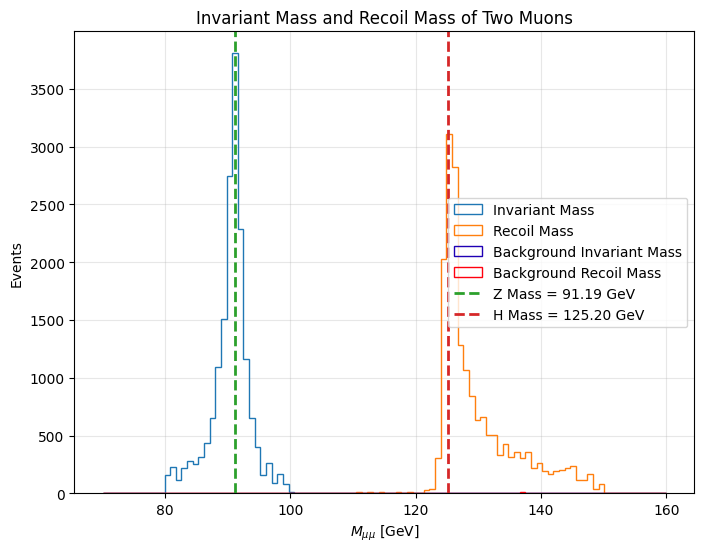

In [16]:
# Call the function
plot_muon_histograms(
    sig_filtered_invMass,
    sig_filtered_recoilMass,
    bg_filtered_invMass,
    bg_filtered_recoilMass,
    z_mass,
    h_mass,
    save_path="muon_histogram.png",   # writes the PNG file
    show=True                         # also pops up the window (optional)
)

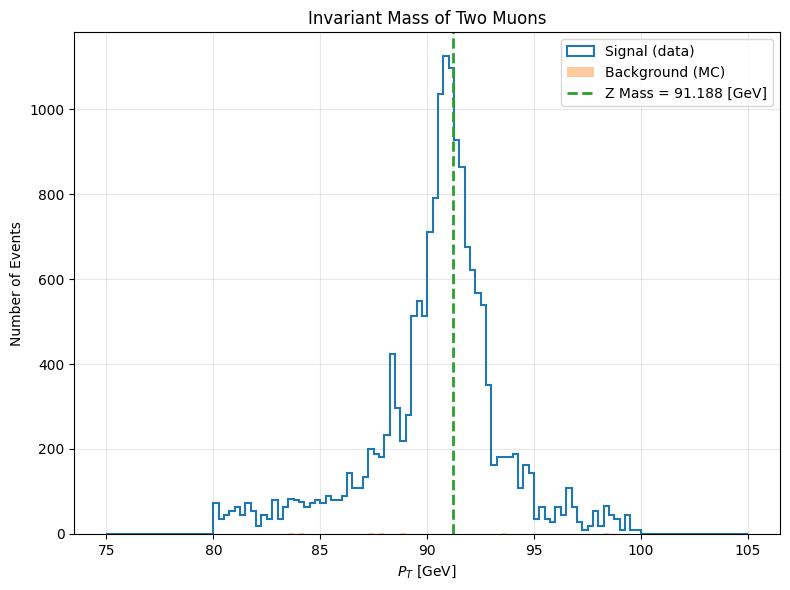

In [17]:
plot_histogram(
    signal_data=sig_filtered_invMass,
    background_data=bg_filtered_invMass,
    v_line=z_mass,
    bins=120,
    range_min=75,
    range_max=105,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Invariant Mass of Two Muons",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="invariant_mass.png",
    show_plot=True,
)

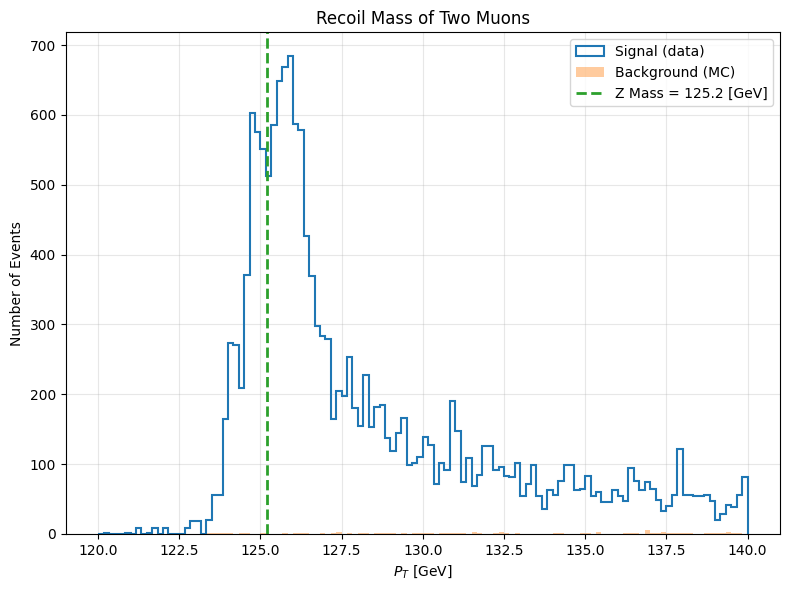

In [18]:
plot_histogram(
    signal_data=sig_filtered_recoilMass,
    background_data=bg_filtered_recoilMass,
    v_line=h_mass,
    bins=120,
    range_min=120,
    range_max=140,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Recoil Mass of Two Muons",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="recoil_mass.png",
    show_plot=True,
)

In [19]:
sig_px = nsig_df["px"]
sig_py = nsig_df["py"]
sig_pz = nsig_df["pz"]

bg_px = nbg_df["px"]
bg_py = nbg_df["py"]
bg_pz = nbg_df["pz"]

In [20]:
def plot_3d_scatter(
    signal_px,
    signal_py,
    signal_pz,
    background_px=None,
    background_py=None,
    background_pz=None,
    *,
    title="Muons 3‑D Momentum Scatter",
    figsize=(8, 6),
    cmap='viridis',
    point_size=30,
    alpha=0.7,
    bg_alpha=0.3,
    save_path="muon_3d_momentum.png",
    show_plot=True,
):
    """
    Create a 3‑D scatter plot of particle momenta.

    Parameters
    ----------
    signal_px, signal_py, signal_pz : array‑like
        Components of the *signal* momentum vectors (e.g. muons).
    background_px, background_py, background_pz : array‑like, optional
        Components of a secondary/background dataset that will be plotted
        with a lighter style.  If any of these are ``None`` the background
        series is omitted.
    figsize : tuple, default (8, 6)
        Size of the Matplotlib figure.
    cmap : str, default 'viridis'
        Colormap used to colour the signal points by their magnitude.
    point_size : float, default 30
        Marker size for the signal points.
    alpha : float, default 0.7
        Opacity for the signal markers.
    bg_alpha : float, default 0.3
        Opacity for the background markers.
    save_path : str, default "muon_3d_momentum.png"
        Where to write the PNG image.
    show_plot : bool, default True
        If ``True`` the figure is displayed via ``plt.show()``.
    """

    # ------------------------------------------------------------------
    # Assemble the signal magnitude for colour mapping
    # ------------------------------------------------------------------
    signal_momenta = np.column_stack((signal_px, signal_py, signal_pz))
    signal_mag = np.linalg.norm(signal_momenta, axis=1)

    # ------------------------------------------------------------------
    # Figure / 3‑D axis setup
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')

    # ------------------------------------------------------------------
    # Plot the main (signal) data
    # ------------------------------------------------------------------
    sc_signal = ax.scatter(
        signal_px,
        signal_py,
        signal_pz,
        c=signal_mag,
        cmap=cmap,
        s=point_size,
        alpha=alpha,
        label='Signal',
    )

    # ------------------------------------------------------------------
    # Optional background scatter
    # ------------------------------------------------------------------
    if (
        background_px is not None
        and background_py is not None
        and background_pz is not None
    ):
        ax.scatter(
            background_px,
            background_py,
            background_pz,
            c='red',
            s=point_size,
            alpha=bg_alpha,
            label='Background',
        )

    # ------------------------------------------------------------------
    # Axis labels, title, colour bar
    # ------------------------------------------------------------------
    ax.set_xlabel(r'$p_x$')
    ax.set_ylabel(r'$p_y$')
    ax.set_zlabel(r'$p_z$')
    ax.set_title(title)
    ax.legend()
    cbar = fig.colorbar(sc_signal, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label(r'$|\vec{p}|$ (magnitude)')

    # ------------------------------------------------------------------
    # Layout, save, optionally show
    # ------------------------------------------------------------------
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)   # free memory when called repeatedly

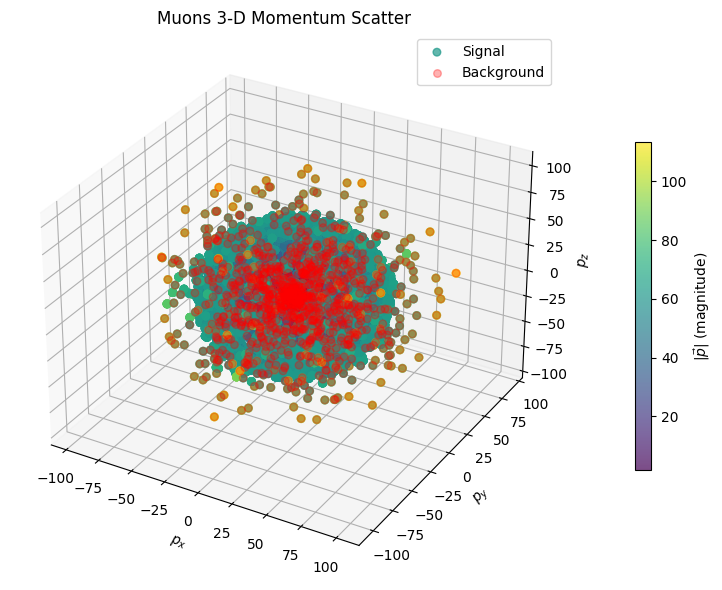

In [21]:
# Call the plotting routine
plot_3d_scatter(
    sig_px,
    sig_py,
    sig_pz,
    background_px=bg_px,
    background_py=bg_py,
    background_pz=bg_pz,
    title="Muons 3‑D Momentum Scatter",
    save_path="my_muon_scatter.png",
    show_plot=True,
)

## Muon Pair Energy Distribution Histogram

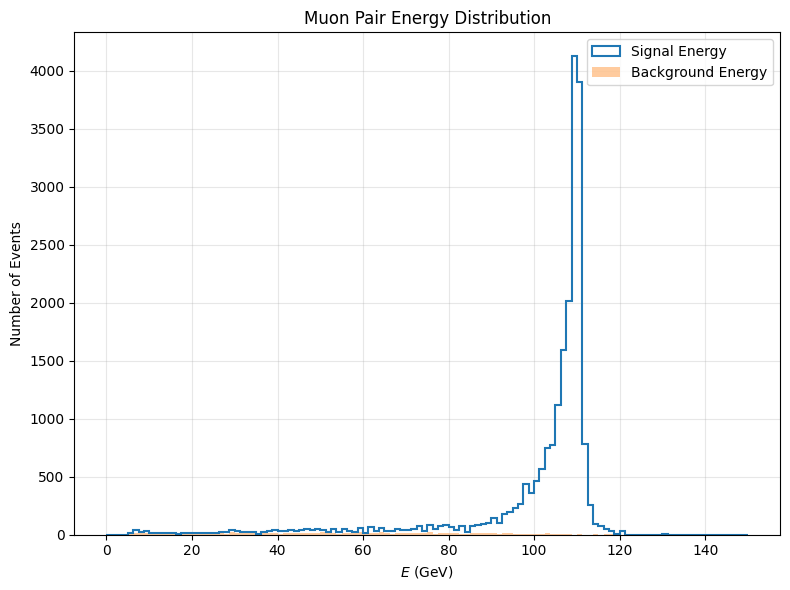

In [22]:
sig_energy = nsig_df["totalEnergy"]
bg_energy = nbg_df["totalEnergy"]

# --------------------------------------------------------------
# Produce the plot
# --------------------------------------------------------------
plot_histogram(
    signal_data=sig_energy,
    background_data=bg_energy,
    bins=120,
    range_min=0,
    range_max=150,
    signal_label="Signal Energy",
    background_label="Background Energy",
    title="Muon Pair Energy Distribution",
    xlabel=r"$E$ (GeV)",
    ylabel="Number of Events",
    save_path="muon_energy_comparison.png",
    show_plot=True,
)

## Transverse Energy of Two Muons Histogram

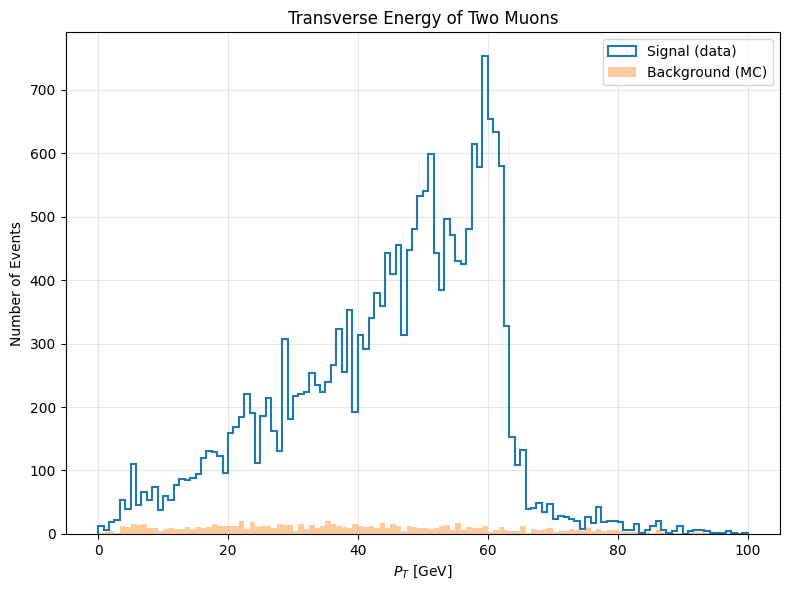

In [23]:
sig_met = nsig_df["met"]
bg_met = nbg_df["met"]

# --------------------------------------------------------------
# Produce the plot
# --------------------------------------------------------------
plot_histogram(
    signal_data=sig_met,
    background_data=bg_met,
    bins=120,
    range_min=0,
    range_max=100,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Transverse Energy of Two Muons",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="muon_energy_comparison.png",
    show_plot=True,
)

### Highest and Lowest Transverse energy muons

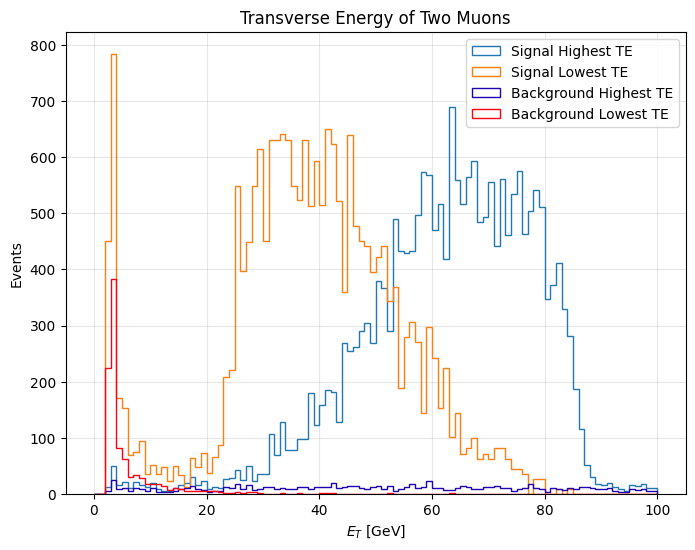

In [24]:
sig_muonEnergy_high = nsig_df["muonEnergy_high"]
sig_muonEnergy_low = nsig_df["muonEnergy_low"]

bg_muonEnergy_high = nbg_df["muonEnergy_high"]
bg_muonEnergy_low = nbg_df["muonEnergy_low"]

# Plot
plt.figure(figsize=(8,6))

# Invariant mass
# Signal
plt.hist(sig_muonEnergy_high, bins=100, range=(0,100), histtype="step", color="#1f77b4", label="Signal Highest TE")
plt.hist(sig_muonEnergy_low, bins=100, range=(0,100), histtype="step", color="#ff7f0e", label="Signal Lowest TE")

# Background
plt.hist(bg_muonEnergy_high, bins=100, range=(0,100), histtype="step", color="#1f00b4", label="Background Highest TE")
plt.hist(bg_muonEnergy_low, bins=100, range=(0,100), histtype="step", color="#ff000e", label="Background Lowest TE")


plt.xlabel(r"$E_{T}$ [GeV]")
plt.ylabel("Events")
plt.title("Transverse Energy of Two Muons")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_transverse_energy.png")

### Missing Energy Histogram

In [25]:
sig_missingEnergy= nsig_df["missingEnergy"]
bg_missingEnergy= nbg_df["missingEnergy"]

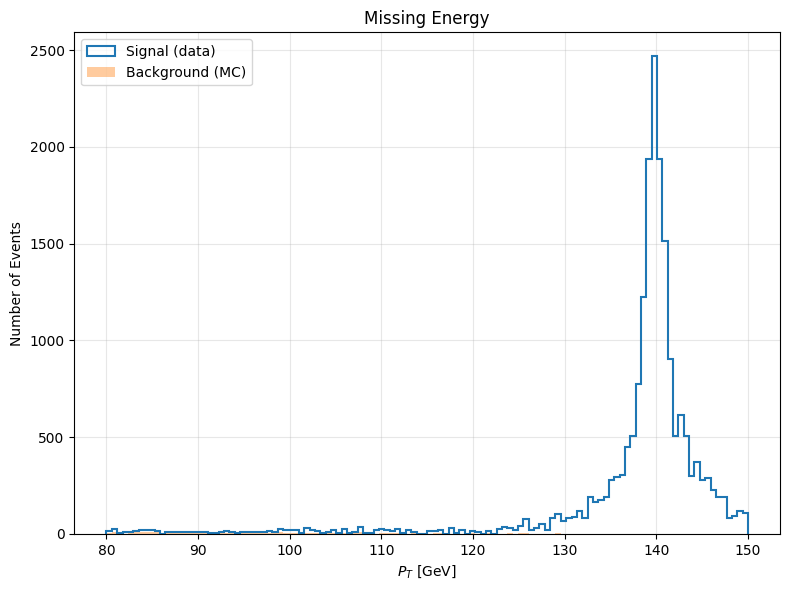

In [26]:
plot_histogram(
    signal_data=sig_missingEnergy,
    background_data=bg_missingEnergy,
    bins=120,
    range_min=80,
    range_max=150,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Missing Energy",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="missing_energy.png",
    show_plot=True,
)

### Muons 3‑D Missing Momentum Scatter

In [27]:
sig_missingPx = nsig_df["missingPx"]
sig_missingPy = nsig_df["missingPy"]
sig_missingPz = nsig_df["missingPz"]

bg_missingPx = nbg_df["missingPx"]
bg_missingPy = nbg_df["missingPy"]
bg_missingPz = nbg_df["missingPz"]

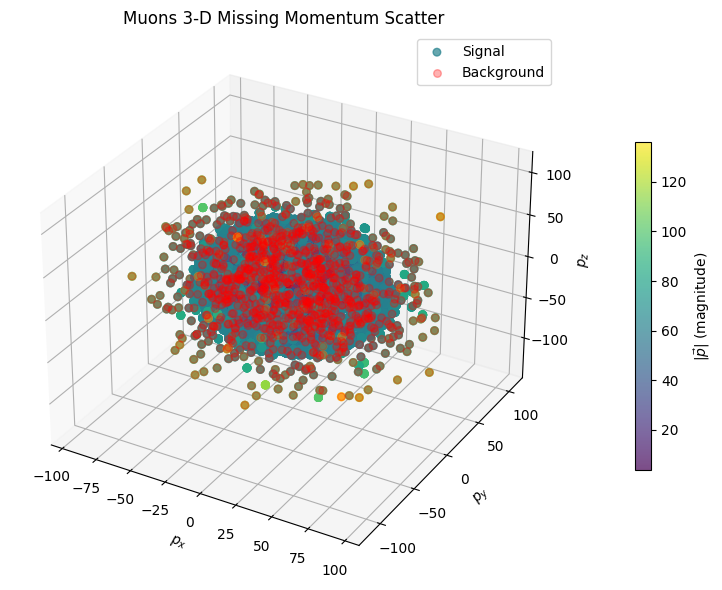

In [28]:
# Call the plotting routine
plot_3d_scatter(
    sig_missingPx,
    sig_missingPy,
    sig_missingPz,
    background_px=bg_missingPx,
    background_py=bg_missingPy,
    background_pz=bg_missingPz,
    title='Muons 3‑D Missing Momentum Scatter',
    save_path="muon_miss_3d_momentum.png",
    show_plot=True,
)

In [29]:
test_path = "/home/mazeeqe/Documents/mestrado/code/tomaz-example/build/hist.root"
test_file = uproot.open(test_path)

# Check Available Keys
print(test_file.keys())

# Import Events
test_tree = test_file["events"]

['events;1', 'NumEventsGenerated;1', 'CrossSection_pb;1', 'TargetLuminosity_fb;1']


In [30]:
test_df = load_histograms(test_path)
print(len(test_df))
test_df.head()

998


,invMass,recoilMass,totalEnergy,muonEnergy_high,muonEnergy_low,px,py,pz,met,missingEnergy,missingPx,missingPy,missingPz,weight
0,71.224838,151.866882,89.018852,69.881767,19.137085,11.450953,-11.392396,50.896633,16.152740,32.861115,-38.579548,16.280138,16.550903,0.1
1,23.850317,158.366302,75.977905,72.553673,3.424232,-27.751377,66.550140,2.178025,72.104515,53.717316,-42.317875,-9.867889,-29.722055,0.1
2,25.498913,142.323151,85.788628,83.049889,2.738738,-19.162386,30.835329,-73.426697,36.304470,38.212524,-34.467552,-22.405886,-5.485229,0.1
3,35.572300,172.790344,67.817772,62.481354,5.336416,-22.043854,53.311394,2.413500,57.689133,68.197586,47.524952,16.847164,-39.099468,0.1
4,20.893509,212.888916,35.229691,31.375854,3.853836,3.810331,-27.980904,-2.672596,28.239149,116.418869,-24.815527,-43.156864,24.667295,0.1


In [31]:
dup_mask = test_df.duplicated()
print(dup_mask)
num_dups = dup_mask.sum()
print(f"Number of duplicate rows: {num_dups}")

0      False
1      False
2      False
3      False
4      False
       ...  
993    False
994    False
995    False
996    False
997    False
Length: 998, dtype: bool
Number of duplicate rows: 0


In [32]:
test_invMass = test_df["invMass"]
test_recoilMass = test_df["recoilMass"]



test_filtered_invMass = filter_between(test_invMass, 80, 100)
test_filtered_recoilMass = filter_between(test_recoilMass, 110, 150)

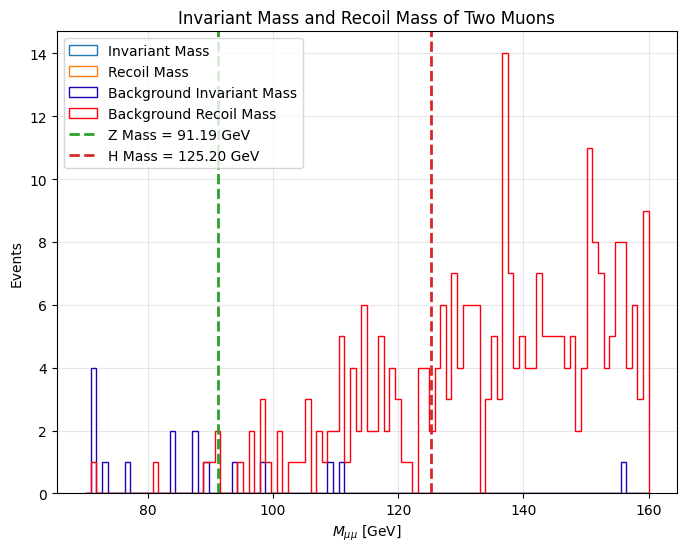

In [33]:
# Call the function
plot_muon_histograms(
    [0],
    [0],
    test_invMass,
    test_recoilMass,
    z_mass,
    h_mass,
    save_path="test.png",   # writes the PNG file
    show=True                         # also pops up the window (optional)
)